In [17]:
import math
import matplotlib.pyplot as plt
import numpy as np
import random
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp

# Lorenz Attractor

We're going to tackle simulating one of the most famous chaotic systems: the Lorenz attractor. We'll start with some simulation technique warmups and then get to the real thing.

## Buffon's Needle

Buffon's Needle is a classic experiment that allows you to probabalistically estimate the value of an irrational number ($\pi$) as an arbitrarily precise fraction. The premise is that you have a flat surface covered in parallel lines, each a distance $l$ apart. Then you drop a needle of length $l$ on the surface at random and note if it ended up lying across any of the lines. Repeat this process $n$ times, incrementing $x$ for each positive result, and observe $\frac{x}{n} \approx \pi$!

In [18]:
def bn(d, l, n):
    xs = [random.uniform(0, d) for _ in range(n)]
    ts = [random.uniform(0, math.pi / 2) for _ in range(n)]
    return [1 if x <= l * math.sin(t) else 0 for x, t in zip(xs, ts)]


def bn_frac(d, l, n):
    hits = sum(bn(d, l, n))
    return ((2 * l) * n) / (d * hits)


for i in range(2, 7):
    print(f"n = {10**i}, pi = {bn_frac(1, 1, 10**i)}")

n = 100, pi = 3.508771929824561
n = 1000, pi = 3.289473684210526
n = 10000, pi = 3.1240237425804436
n = 100000, pi = 3.133912062427528
n = 1000000, pi = 3.144248697494977


## Random Telegraph Signal

The Random Telegraph Signal or Telegraph Process is a two-state process that models burst noise (essentially radio static). You start with a signal in a given state (off or on) and then at each time step $\tau$ sample a Poisson distribution to determine how many switches occur in that time step. Within each step $\tau$ you then apply state switches at times $t_x$. This is an important concept for modeling any systems affected by stochastic processes (any real, physical system for example).

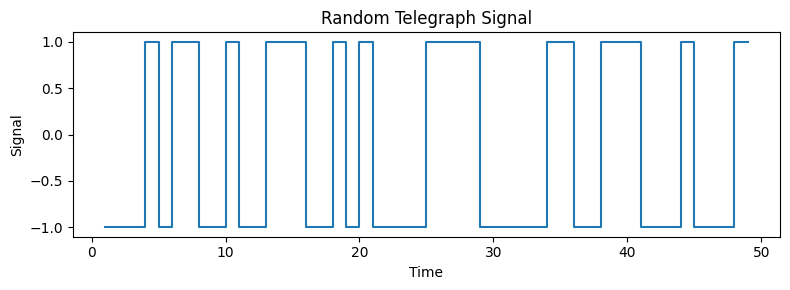

In [19]:
def rts(lam, intervals):
    ns = np.random.poisson(lam, intervals)
    points = []
    current = 1
    for j, n in enumerate(ns):
        n = max(n, 1)
        for i in range(n):
            t = j + i / n
            points.append((t, current))
            current *= -1
        points.append((j + 1, current))
    return points


def process_rts(data, step):
    times = np.arange(1, int(data[-1][0]), step)
    idx, result = 0, []
    for t in times:
        while idx < len(data) and data[idx][0] <= t:
            idx += 1
        result.append(data[idx - 1][1] if idx > 0 else 1)
    return times, result


rts_data = process_rts(rts(5, 50), 1)

plt.figure(figsize=(8, 3))
plt.step(rts_data[0], rts_data[1], where="post")
plt.xlabel("Time")
plt.ylabel("Signal")
plt.title("Random Telegraph Signal")
plt.tight_layout()
plt.show()

## Lorenz Attractor

The Lorenz attractor is a three dimensional nonlinear system. It is defined by three equations $\frac{\delta x}{\delta t} = \sigma (y - x)$, $\frac{\delta y}{\delta t} = x (\rho - z) - y$, $\frac{\delta z}{\delta t} = x y - \beta z$ and is parameterized by the three variables $\sigma$, $\rho$, and $\beta$. Many parameter sets yield a fairly boring system but there are some that exist in the system's chaotic regime. We're using the most famous set here: $\sigma = 10$, $\rho = 28$, and $\beta = 8/3$.

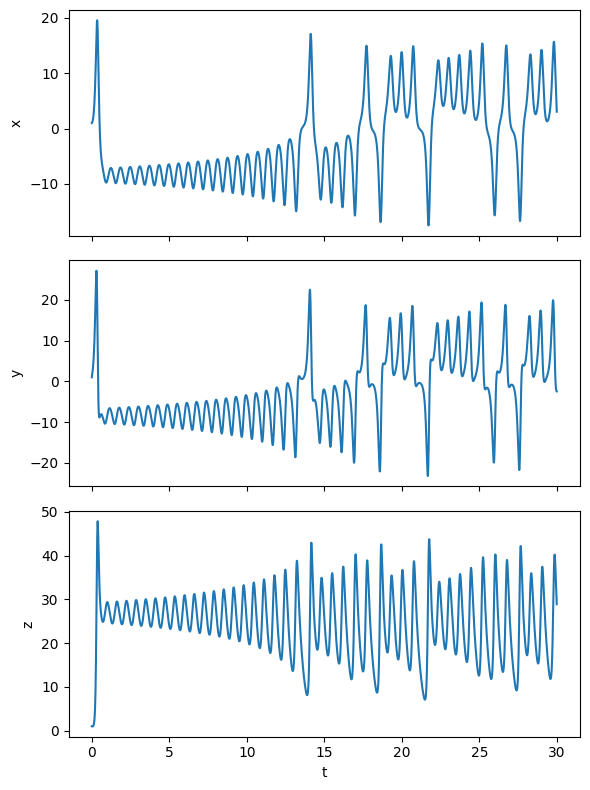

In [20]:
sigma = 10
rho = 28
beta = 8 / 3
t_span = (0, 30)
y0 = [1, 1, 1]


def lorenz(t, xyz):
    x, y, z = xyz
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]


sol = solve_ivp(lorenz, t_span, y0, max_step=0.01)
t = sol.t
x, y, z = sol.y
fig, axes = plt.subplots(3, 1, figsize=(6, 8), sharex=True)
axes[0].plot(t, x)
axes[0].set_ylabel("x")
axes[1].plot(t, y)
axes[1].set_ylabel("y")
axes[2].plot(t, z)
axes[2].set_ylabel("z")
axes[2].set_xlabel("t")
plt.tight_layout()
plt.show()

What you're seeing here is each of $x$, $y$, and $z$ plotted as the system evolves. They look kind of chaotic but nothing all that shocking. A more interesting way of displaying this system is by plotting the path that $x$, $y$, and $z$ take through space as the system evolves. One way of conceptualizing the system now is as a "thing" with a gravitational pull (this is where the term "attractor" came from). As some object orbits around it, we trace that object's path.

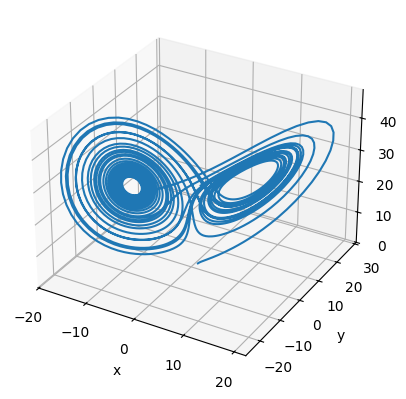

In [21]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection="3d")
ax.plot(x, y, z)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.tight_layout()
plt.show()

That's a much more interesting result! You can almost imagine a planet orbitting around this sort of double-centered attactor. One of the notable features of this that gives us a big hint it is properly chaotic is the sporadic line spacing between traces. As you increase the simulation time you will see those spaces continue to fill until it's a completely filled surface (or the computer hits a rounding error and begins retracing its steps). This is a result of the ability of tiny differences to result in different trajectories over time.

We can see an even better example of that below, running two simulations side by side with slightly different starting points. Looking at the three dimensional plot of them, they both still adhere to the behavior of the attractor. But looking at the sum of the absolute value of the difference in $y$ values as the systems evlove, we can see that the two separate at an exponential rate before reaching a maximum average distance from each other. This is what's known as the Butterfly Effect; two identical, nonlinear systems starting at near identical positions and taking exponentially diverging paths.

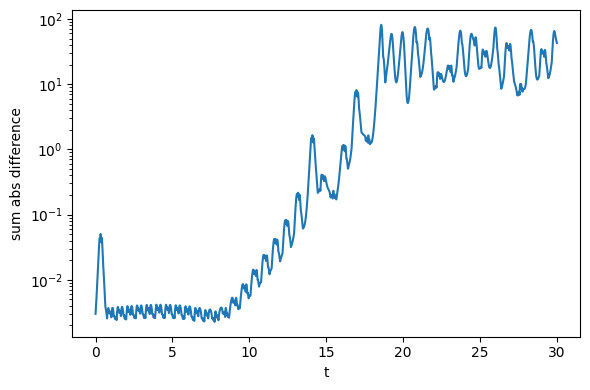

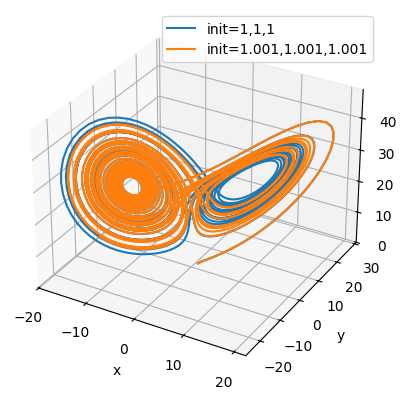

In [22]:
y0_a = [1, 1, 1]
y0_b = [1.001, 1.001, 1.001]
sol_a = solve_ivp(lorenz, t_span, y0_a, max_step=0.01)
sol_b = solve_ivp(lorenz, t_span, y0_b, max_step=0.01)
diff = np.abs(sol_a.y - sol_b.y).sum(axis=0)
plt.figure(figsize=(6, 4))
plt.plot(sol_a.t, diff)
plt.yscale("log")
plt.xlabel("t")
plt.ylabel("sum abs difference")
plt.tight_layout()
plt.show()
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection="3d")
ax.plot(sol_a.y[0], sol_a.y[1], sol_a.y[2], label="init=1,1,1")
ax.plot(sol_b.y[0], sol_b.y[1], sol_b.y[2], label="init=1.001,1.001,1.001")
ax.legend()
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.tight_layout()
plt.show()